In [1]:
# set_determinism : monai에서 제공하는 seed값 고정 util.
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    MapLabelValued,
    ConcatItemsd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [44]:
root_dir = '/data/train/running/l/input_augmented'

# good case
# basename = 's_f_SU0511_12_dn'

# bad case
basename = 's_f_16100703_02_d'

train_images = sorted(
    glob.glob(os.path.join(root_dir, basename + "_b.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(root_dir, basename + "_l.nii.gz")))
train_brains = sorted(
    glob.glob(os.path.join(root_dir, basename + "*_b.nii.gz")))
train_masks = sorted(
    glob.glob(os.path.join(root_dir, basename + "*_m.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name, "brain": brain_name, "mask": mask_name}
    for image_name, label_name, brain_name, mask_name in zip(train_images, train_labels, train_brains, train_masks)
]
train_files = data_dicts
train_files

[{'image': '/data/train/running/l/input_augmented/s_f_16100703_02_d_b.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_f_16100703_02_d_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_f_16100703_02_d_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_f_16100703_02_d_m.nii.gz'}]

In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Orientationd(keys=["image"], axcodes="LPS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
    ]
)

In [54]:
import numpy as np
from monai.transforms import (
    AddChanneld,
    CastToTyped,
    Compose,
    CropForegroundd,
    LoadImaged,
    NormalizeIntensity,
    Orientationd,
    Rand3DElasticd,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotated,
    RandScaleIntensityd,
    RandZoomd,
    SpatialCrop,
    SpatialPadd,
    EnsureTyped,
    MapLabelValued,
    ConcatItemsd,
    DeleteItemsd,
    SelectItemsd,
    RandCropByLabelClassesd,
)
from monai.transforms.compose import MapTransform
from monai.transforms.utils import generate_spatial_bounding_box
from skimage.transform import resize


pos_sample_num = 1
neg_sample_num = 1
clip_values = [0, 0]
spacing = [1.0, 1.0, 1.0]
normalize_values = [0, 0]

orig_label_classes, target_label_classes = (
    np.array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
          15,   16,   17,   18,   24,   26,   28,   30,   31,   41,   43,
          44,   46,   47,   49,   50,   51,   52,   53,   54,   58,   60,
          62,   63,   77,   85,  251,  252,  253,  254,  255, 1000, 1002,
        1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
        1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
        1026, 1027, 1028, 1029, 1030, 1031, 1034, 1035, 2000, 2002, 2003,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
        2027, 2028, 2029, 2030, 2031, 2034, 2035]),
    np.array([   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105], dtype=np.uint8)
    )

def get_train_transform(patch_size, num_samples):
    keys = ["image", "label", "brain", "mask"]
    transforms = [
        LoadImaged(keys=keys),
        AddChanneld(keys=keys),
        Orientationd(keys=keys, axcodes="RAS"),
        MapLabelValued(
            keys=["label"], 
            orig_labels=orig_label_classes, 
            target_labels=target_label_classes,
            dtype=np.uint8
        ),
        # ConcatItemsd(keys=["image", "mask"], name="image"),
        # DeleteItemsd(
        #     keys=["mask"]
        # ),
        # SelectItemsd(
        #     keys=["image", "label", 
        #           "image_meta_dict", "label_meta_dict", 
        #           "image_transforms", "label_transforms"]
        # ),
        PreprocessAnisotropic(
            # keys=keys,
            keys=["image", "label"],
            clip_values=clip_values,
            pixdim=spacing,
            normalize_values=normalize_values,
            model_mode="train",
        ),
        SpatialPadd(keys=keys, spatial_size=patch_size),
#         RandCropByPosNegLabeld(
#             # keys=keys,
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=patch_size,
#             pos=pos_sample_num,
#             neg=neg_sample_num,
#             num_samples=num_samples,
#             image_key="image",
#             image_threshold=0,
#         ),
        # RandCropByLabelClassesd(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=patch_size,
        #     image_key="image",
        #     num_samples=num_samples,
        #     num_classes=106,
        #     image_threshold=0,
        # ),
        # Rand3DElasticd(
        #     keys=["image", "label"],
        #     mode=("bilinear", "nearest"),
        #     prob=1.0,
        #     sigma_range=(5, 8),
        #     magnitude_range=(100, 200),
        #     # padding_mode="border",
        #     padding_mode="zeros",
        # ),
        # RandZoomd(
        #     keys=keys,
        #     min_zoom=0.9,
        #     max_zoom=1.2,
        #     mode=("trilinear", "nearest"),
        #     align_corners=(True, None),
        #     prob=0.15,
        # ),
        # RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
        # RandGaussianSmoothd(
        #     keys=["image"],
        #     sigma_x=(0.5, 1.15),
        #     sigma_y=(0.5, 1.15),
        #     sigma_z=(0.5, 1.15),
        #     prob=0.15,
        # ),
        # RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
        # RandFlipd(keys, spatial_axis=[0], prob=0.5),
        # RandRotated(
        #     keys=keys,
        #     mode=("bilinear", "nearest"),
        #     range_x=np.pi / 18,
        #     range_y=np.pi / 18,
        #     range_z=np.pi / 18,
        #     prob=1.0,
        #     # padding_mode=("reflection", "reflection"),
        #     padding_mode="zeros",
        # ),
        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        EnsureTyped(keys=["image", "label"]),
#         DeleteItemsd(
#             keys=["mask", "mask_meta_dict", "mask_transforms"]
#         ),
    ]
    return Compose(transforms)



def resample_image(image, shape, anisotrophy_flag):
    resized_channels = []
    if anisotrophy_flag:
        for image_c in image:
            resized_slices = []
            for i in range(image_c.shape[-1]):
                image_c_2d_slice = image_c[:, :, i]
                image_c_2d_slice = resize(
                    image_c_2d_slice,
                    shape[:-1],
                    order=3,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                resized_slices.append(image_c_2d_slice)
            resized = np.stack(resized_slices, axis=-1)
            resized = resize(
                resized,
                shape,
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            resized_channels.append(resized)
    else:
        for image_c in image:
            resized = resize(
                image_c,
                shape,
                order=3,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            resized_channels.append(resized)
    resized = np.stack(resized_channels, axis=0)
    return resized


def resample_label(label, shape, anisotrophy_flag):
    reshaped = np.zeros(shape, dtype=np.uint8)
    n_class = np.max(label)
    if anisotrophy_flag:
        shape_2d = shape[:-1]
        depth = label.shape[-1]
        reshaped_2d = np.zeros((*shape_2d, depth), dtype=np.uint8)

        for class_ in range(1, int(n_class) + 1):
            for depth_ in range(depth):
                mask = label[0, :, :, depth_] == class_
                resized_2d = resize(
                    mask.astype(float),
                    shape_2d,
                    order=1,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                reshaped_2d[:, :, depth_][resized_2d >= 0.5] = class_
        for class_ in range(1, int(n_class) + 1):
            mask = reshaped_2d == class_
            resized = resize(
                mask.astype(float),
                shape,
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[resized >= 0.5] = class_
    else:
        for class_ in range(1, int(n_class) + 1):
            mask = label[0] == class_
            resized = resize(
                mask.astype(float),
                shape,
                order=1,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[resized >= 0.5] = class_

    reshaped = np.expand_dims(reshaped, 0)
    return reshaped


def recovery_prediction(prediction, shape, anisotrophy_flag):
    reshaped = np.zeros(shape, dtype=np.uint8)
    n_class = shape[0]
    if anisotrophy_flag:
        c, h, w = prediction.shape[:-1]
        d = shape[-1]
        reshaped_d = np.zeros((c, h, w, d), dtype=np.uint8)
        for class_ in range(1, n_class):
            mask = prediction[class_] == 1
            resized_d = resize(
                mask.astype(float),
                (h, w, d),
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped_d[class_][resized_d >= 0.5] = 1

        for class_ in range(1, n_class):
            for depth_ in range(d):
                mask = reshaped_d[class_, :, :, depth_] == 1
                resized_hw = resize(
                    mask.astype(float),
                    shape[1:-1],
                    order=1,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                reshaped[class_, :, :, depth_][resized_hw >= 0.5] = 1
    else:
        for class_ in range(1, n_class):
            mask = prediction[class_] == 1
            resized = resize(
                mask.astype(float),
                shape[1:],
                order=1,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[class_][resized >= 0.5] = 1

    return reshaped


class PreprocessAnisotropic(MapTransform):
    """
        This transform class takes NNUNet's preprocessing method for reference.
        That code is in:
        https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/preprocessing/preprocessing.py

    """

    def __init__(
        self,
        keys,
        clip_values,
        pixdim,
        normalize_values,
        model_mode,
    ) -> None:
        super().__init__(keys)
        self.keys = keys
        self.low = clip_values[0]
        self.high = clip_values[1]
        self.target_spacing = pixdim
        self.mean = normalize_values[0]
        self.std = normalize_values[1]
        self.training = False
        self.crop_foreg = CropForegroundd(keys=["image", "label"], source_key="image")
        self.normalize_intensity = NormalizeIntensity(nonzero=True, channel_wise=True)
        if model_mode in ["train"]:
            self.training = True

    def calculate_new_shape(self, spacing, shape):
        spacing_ratio = np.array(spacing) / np.array(self.target_spacing)
        new_shape = (spacing_ratio * np.array(shape)).astype(int).tolist()
        return new_shape

    def check_anisotrophy(self, spacing):
        def check(spacing):
            return np.max(spacing) / np.min(spacing) >= 3

        return check(spacing) or check(self.target_spacing)

    def __call__(self, data):
        # load data
        d = dict(data)
        image = d["image"]
        image_spacings = d["image_meta_dict"]["pixdim"][1:4].tolist()

        if "label" in self.keys:
            label = d["label"]
            label[label < 0] = 0

        if self.training:
            # only task 04 does not be impacted
            cropped_data = self.crop_foreg({"image": image, "label": label})
            image, label = cropped_data["image"], cropped_data["label"]
        else:
            d["original_shape"] = np.array(image.shape[1:])
            box_start, box_end = generate_spatial_bounding_box(image)
            image = SpatialCrop(roi_start=box_start, roi_end=box_end)(image)
            d["bbox"] = np.vstack([box_start, box_end])
            d["crop_shape"] = np.array(image.shape[1:])

        original_shape = image.shape[1:]
        # calculate shape
        resample_flag = False
        anisotrophy_flag = False
        if self.target_spacing != image_spacings:
            # resample
            resample_flag = True
            resample_shape = self.calculate_new_shape(image_spacings, original_shape)
            anisotrophy_flag = self.check_anisotrophy(image_spacings)
            image = resample_image(image, resample_shape, anisotrophy_flag)
            if self.training:
                label = resample_label(label, resample_shape, anisotrophy_flag)

        d["resample_flag"] = resample_flag
        d["anisotrophy_flag"] = anisotrophy_flag
        # clip image for CT dataset
        if self.low != 0 or self.high != 0:
            image = np.clip(image, self.low, self.high)
            image = (image - self.mean) / self.std
        else:
            image = self.normalize_intensity(image.copy())

        d["image"] = image

        if "label" in self.keys:
            d["label"] = label

        return d

patch_size = [96, 96, 96]
num_samples = 8
transform = get_train_transform(patch_size, num_samples)

torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
image shape: torch.Size([186, 230, 230]), label shape: torch.Size([186, 230, 230])


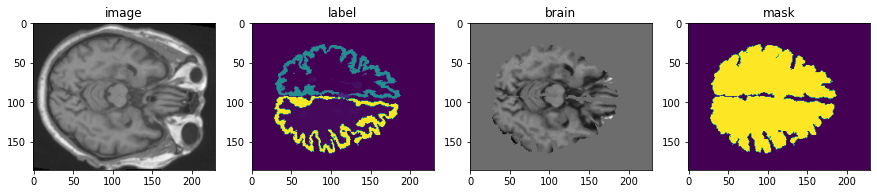

In [9]:
H=100

check_ds = Dataset(data=train_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
brain, mask = (check_data["brain"][0][0], check_data["mask"][0][0])
print(check_data['image'].shape, check_data['label'].shape)
print(check_data['brain'].shape, check_data['mask'].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 10))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image[:, :, H], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("label")
plt.imshow(label[:, :, H])
plt.subplot(1, 4, 3)
plt.title("brain")
plt.imshow(brain[:, :, H], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(mask[:, :, H])
plt.show()

torch.Size([1, 1, 151, 182, 127]) torch.Size([1, 1, 151, 182, 127])
torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
image shape: torch.Size([151, 182, 127]), label shape: torch.Size([151, 182, 127])


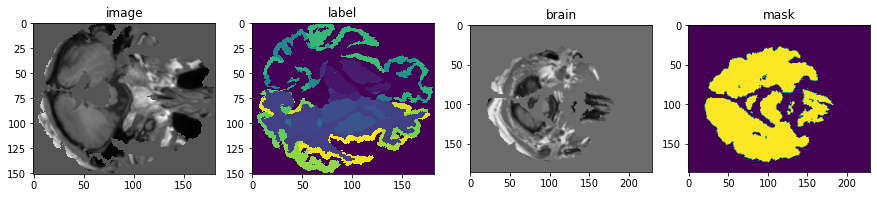

In [55]:
H=45

check_ds = Dataset(data=train_files, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
brain, mask = (check_data["brain"][0][0], check_data["mask"][0][0])
print(check_data['image'].shape, check_data['label'].shape)
print(check_data['brain'].shape, check_data['mask'].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 10))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image[:, :, H], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("label")
plt.imshow(label[:, :, H])
plt.subplot(1, 4, 3)
plt.title("brain")
plt.imshow(brain[:, :, H], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(mask[:, :, H])
plt.show()

In [53]:
np.where(label == 0)

(array([ 6,  7,  7, ..., 63, 63, 63]),
 array([100,  97,  97, ...,  67,  68,  69]),
 array([ 63,  61,  62, ..., 121, 121, 121]))

In [56]:
label

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,